In [1]:
import numpy as np
import xarray as xray
import pandas as pd
import datetime
import cPickle as pickle

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
%matplotlib inline

matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

In [2]:
ds = xray.open_dataset('/Users/jet/data/era_interim/era_interim_curl.nc')
ds_grid = xray.open_dataset('/Users/jet/data/era_interim/era_interim_grid.nc')

In [3]:
south=38
north=72
west=-70
east=-10

In [4]:
curl = ds.curl.sel(lat=slice(south,north),lon=slice(west,east))

In [5]:
curl_mean = curl.mean('time')

In [6]:
ds.lsm.values = ds.lsm.values.astype(np.float)
ds.lsm.values[ds.lsm.values==1] = np.nan
ds.lsm.values[ds.lsm.values==0] = 1

In [7]:
ds_dpth = xray.open_dataset('/Users/jet/data/RG_ArgoClim/RG_ArgoClim_isopycnal_depth.nc')
dpth = ds_dpth.depth
dpth_277 = dpth.sel(sigma=27.70)

In [8]:
nc = xray.open_dataset('/Users/jet/data/mdt_cnes_cls2013_global.nc',decode_times=False)

nc_l = nc.sel(lon=slice(180,380))
nc_l['lon'] = nc_l['lon'] - 360
nc_r = nc.sel(lon=slice(0,180))

ds_mdt = xray.concat([nc_l,nc_r],dim='lon')
mdt = ds_mdt.mdt.sel(time=0)

In [9]:
# Northwest
patch01_lats = [45, 70, 70, 45]
patch01_lons = [-65, -65, -15, -15]

# Subpolar gyre core
patch02_lats = [49, 59, 59, 49]
patch02_lons = [-48, -48, -43, -43]

# Subpolar gyre 
patch03_lats = [50, 65, 65, 50]
patch03_lons = [-60, -60, -30, -30]

# East of Greenland
patch04_lats = [57, 68, 68, 57]
patch04_lons = [-43, -43, -25, -25]

In [10]:
curl_subset = ds.curl.sel(lat=slice(np.min(patch04_lats),np.max(patch04_lats)),
                          lon=slice(np.min(patch04_lons),np.max(patch04_lons)))*ds.lsm

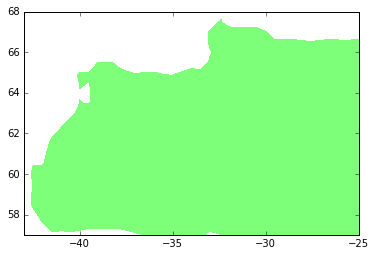

In [40]:
p0 = plt.contourf(curl_subset.lon,curl_subset.lat,
                  np.ma.masked_invalid(curl_subset.mean('time')),
                  levels=[0.05*10**-6,np.max(curl_subset.mean('time'))],cmap='jet')

# Get contour line of selected area
path = p0.collections[0].get_paths()[0]
v = path.vertices

x0 = v[0,0]
y0 = v[0,1]
count = 0
for (x,y) in v:
    if count >0 and x == x0 and y == y0:
        break;
    #print (count,x,y)
    count += 1

In [12]:
bounds = np.array([-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,-0.02,-0.01,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
ticks = np.array([-0.5,-0.4,-0.3,-0.2,-0.1,-0.05,-0.02,0,0.02,0.05,0.1,0.2,0.3,0.4,0.5])

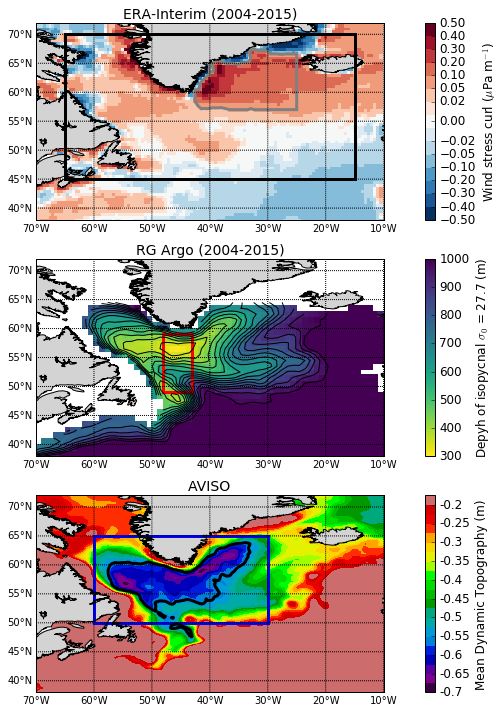

In [13]:
f,axes = plt.subplots(3,1,figsize=(15,12))

plt.subplot(3,1,1)
plt.title('ERA-Interim (2004-2015)',fontsize=14)
m = Basemap(projection='cyl',llcrnrlat=38, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-80,90,5),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-70,10,10),labels=[0,0,0,1], fontsize=10)
p = m.pcolormesh(curl_mean.lon-0.25,curl_mean.lat-0.25,
                 np.ma.masked_invalid(curl_mean*ds.lsm*10**6),
                 cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
patch01 = Polygon(zip(patch01_lons, patch01_lats), facecolor='none',
                  edgecolor='black', linewidth=3)
plt.gca().add_patch(patch01)
patch04 = Polygon(v[0:count], facecolor='none',edgecolor='grey', linewidth=3)
plt.gca().add_patch(patch04)
cb = f.colorbar(p,ticks=ticks)
cb.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=12)
cb.ax.tick_params(labelsize=12)

plt.subplot(3,1,2)
plt.title('RG Argo (2004-2015)',fontsize=14)
m = Basemap(projection='cyl',llcrnrlat=38, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-80,90,5),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-70,10,10),labels=[0,0,0,1], fontsize=10)
p = m.pcolormesh(dpth_277.lon-0.5,dpth_277.lat-0.5,np.ma.masked_invalid(dpth_277.mean('time')),
                 cmap='viridis_r',vmin=300,vmax=1000)
plt.contour(dpth_277.lon,dpth_277.lat,np.ma.masked_invalid(dpth_277.mean('time')),
            vmin=300,vmax=1000, levels=np.linspace(300,1000,15),colors='k',linewidths=1.0)
patch02 = Polygon(zip(patch02_lons, patch02_lats), facecolor='none',
                  edgecolor='red', linewidth=3)
plt.gca().add_patch(patch02)
cb = f.colorbar(p,ticks=np.linspace(300,1000,8))
cb.set_label(r'Depyh of isopycnal $\sigma_0$ = 27.7 (m)',fontsize=12)
cb.ax.tick_params(labelsize=12)

plt.subplot(3,1,3)
plt.title('AVISO',fontsize=14)
m = Basemap(projection='cyl',llcrnrlat=38, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgray')
m.drawcoastlines()
m.drawparallels(np.arange(-80,90,5),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-70,10,10),labels=[0,0,0,1], fontsize=10)
p = plt.contourf(mdt.lon, mdt.lat,np.ma.masked_invalid(np.clip(mdt,-0.8,-0.175)),
                 cmap='spectral',levels=np.arange(-0.7,-0.15,0.025))
plt.contour(mdt.lon, mdt.lat, np.ma.masked_invalid(mdt),
            levels=np.linspace(-0.56,-0.56,1),colors='k',linewidths=3.0)
patch03= Polygon(zip(patch03_lons, patch03_lats), facecolor='none',
                 edgecolor='b', linewidth=3)
plt.gca().add_patch(patch03)
cb = f.colorbar(p, ticks=np.arange(-0.7,-0.15,0.05))
cb.set_label(r'Mean Dynamic Topography (m)',fontsize=12)
cb.ax.set_yticklabels(np.arange(-0.7,-0.15,0.05))
cb.ax.tick_params(labelsize=12)

#plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()

In [14]:
def patch_mean(data, area, lsm, patch_lats, patch_lons):
    
    patch = data.sel(lat=slice(np.min(patch_lats),np.max(patch_lats)),
                     lon=slice(np.min(patch_lons),np.max(patch_lons)))
    area_patch = ((patch/patch)*area*lsm).sum(dim=['lat','lon'])
    patch_mean = (patch*area*lsm/area_patch).sum(dim=['lat','lon'])
        
    return patch_mean

In [15]:
curl01 = patch_mean(ds.curl,ds_grid.area,ds.lsm,patch01_lats,patch01_lons).resample('MS', dim='time', how='mean')
curl02 = patch_mean(ds.curl,ds_grid.area,ds.lsm,patch02_lats,patch02_lons).resample('MS', dim='time', how='mean')
curl03 = patch_mean(ds.curl,ds_grid.area,ds.lsm,patch03_lats,patch03_lons).resample('MS', dim='time', how='mean')

In [16]:
curl_patch04 = curl_subset.where(curl_mean*ds.lsm>0.05*10**-6)
area_patch04 = ((curl_patch04/curl_patch04)*ds_grid.area*ds.lsm).sum(dim=['lat','lon'])
curl04 = (curl_patch04*ds_grid.area*ds.lsm/area_patch04).sum(dim=['lat','lon']).resample('MS', dim='time', how='mean')

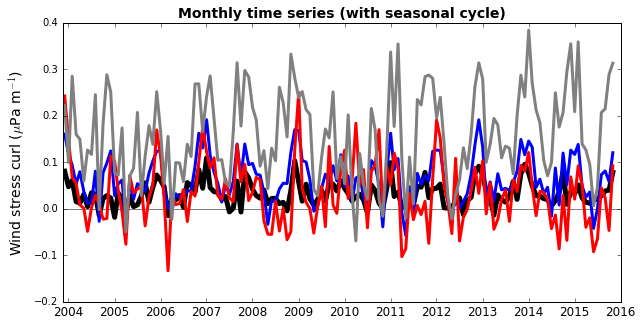

In [17]:
fig = plt.figure(figsize=(10,5))

plt.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')

plt.plot(curl01.time, curl01*10**6, label=r'Northwest Atlantic (>45$^\circ$N)',
         lw=5, color='k')
plt.plot(curl03.time, curl03*10**6, label='Subpolar gyre', lw=3, color='b', linestyle='-')
plt.plot(curl02.time, curl02*10**6, label='Subpolar gyre (core)', 
         lw=3, color='r', linestyle='-')
plt.plot(curl04.time, curl04*10**6, label='East of Greenland', 
         lw=3, color='grey', linestyle='-')

plt.xlim(['2003-12-15','2016-01-15'])
plt.xticks(pd.date_range('2004-01-01','2017-01-01',freq='12M'),fontsize=12)

#plt.ylim([-0.15,0.6])
#plt.yticks(np.arange(-0.1,0.7,0.1),fontsize=12)
plt.ylabel(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
#plt.legend(loc='upper right', frameon=False, fontsize=12)
plt.title('Monthly time series (with seasonal cycle)',fontsize=14,fontweight='bold')

#plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()

In [18]:
cl01 = curl01.groupby('time.month').mean('time')
cl02 = curl02.groupby('time.month').mean('time')
cl03 = curl03.groupby('time.month').mean('time')
cl04 = curl04.groupby('time.month').mean('time')

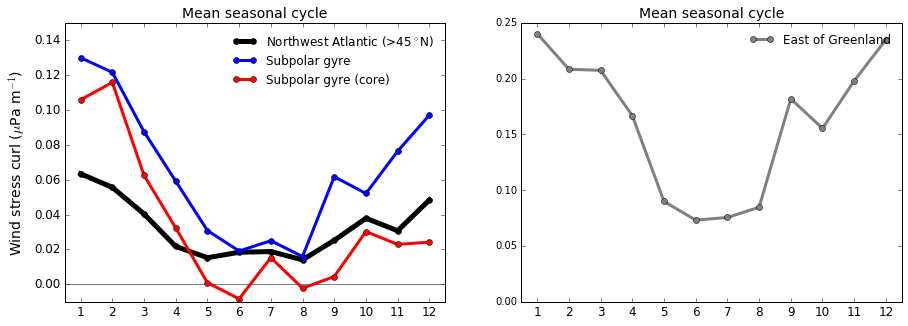

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

plt.subplot(1,2,1)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
plt.plot(cl01.month, cl01*10**6, label=r'Northwest Atlantic (>45$^\circ$N)', lw=5, color='k', marker='o')
plt.plot(cl03.month, cl03*10**6, label='Subpolar gyre', lw=3, color='b', linestyle='-',marker='o')
plt.plot(cl02.month, cl02*10**6, label='Subpolar gyre (core)', lw=3, color='r', linestyle='-',marker='o')
plt.xlim([0.5,12.5])
plt.xticks(np.arange(1,13,1),fontsize=12)
plt.ylim([-0.01,0.15])
plt.yticks(np.arange(0,0.16,0.02),fontsize=12)
plt.ylabel(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
plt.legend(frameon=False, fontsize=12)
plt.title('Mean seasonal cycle',fontsize=14)

plt.subplot(1,2,2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
plt.plot(cl04.month, cl04*10**6, label='East of Greenland', lw=3, color='grey', linestyle='-',marker='o')
plt.xlim([0.5,12.5])
plt.xticks(np.arange(1,13,1),fontsize=12)
#plt.ylim([-0.01,0.15])
#plt.yticks(np.arange(0,0.16,0.02),fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.title('Mean seasonal cycle',fontsize=14)

#plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()

In [20]:
an01 = curl01.groupby('time.month') - cl01
an02 = curl02.groupby('time.month') - cl02
an03 = curl03.groupby('time.month') - cl03
an04 = curl04.groupby('time.month') - cl04

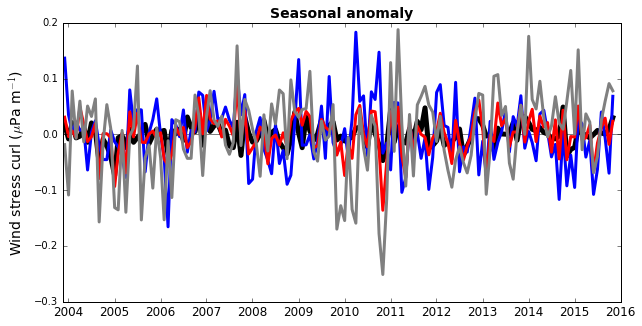

In [21]:
fig = plt.figure(figsize=(10,5))

plt.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')

plt.plot(an01.time, an01*10**6, label=r'Northwest Atlantic (>45$^\circ$N)', lw=5, color='k')
plt.plot(an02.time, an02*10**6, label='Subpolar gyre', lw=3, color='b', linestyle='-')
plt.plot(an03.time, an03*10**6, label='Subpolar gyre (core)', lw=3, color='r', linestyle='-')
plt.plot(an04.time, an04*10**6, label='East of Greenland', lw=3, color='grey', linestyle='-')

plt.xlim(['2003-12-15','2016-01-15'])
plt.xticks(pd.date_range('2004-01-01','2017-01-01',freq='12M'),fontsize=12)
plt.ylabel(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
#plt.legend(frameon=False, fontsize=12)
plt.title('Seasonal anomaly',fontsize=14,fontweight='bold')

#plt.legend(fontsize=12)

#plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()

In [22]:
#df_curl = curl04.to_dataframe(name='curl').reset_index()
#df_curl = curl02.to_dataframe(name='curl').reset_index()
#df_curl = curl01.to_dataframe(name='curl').reset_index()
df_curl = curl03.to_dataframe(name='curl').reset_index()

df_curl.time = pd.DatetimeIndex(df_curl.time)
df_curl.time = df_curl.time.map(lambda x: datetime.datetime(x.year,x.month,15))

In [23]:
#df_curl_an = an04.to_dataframe(name='dcurl').reset_index()
#df_curl_an = an02.to_dataframe(name='dcurl').reset_index()
#df_curl_an = an01.to_dataframe(name='dcurl').reset_index()
df_curl_an = an03.to_dataframe(name='dcurl').reset_index()

df_curl_an.time = pd.DatetimeIndex(df_curl_an.time)
df_curl_an.time = df_curl_an.time.map(lambda x: datetime.datetime(x.year,x.month,15))

In [24]:
df_curl.head()

,time,curl
0,2004-01-15,1.607854e-07
1,2004-02-15,1.176603e-07
2,2004-03-15,9.380494e-08
3,2004-04-15,5.342742e-08
4,2004-05-15,7.974830e-08


In [25]:
df_curl['curl'] = df_curl.curl*10**6

In [26]:
df_curl['dcurl'] = df_curl_an.dcurl*10**6
df_curl.head()

,time,curl,dcurl
0,2004-01-15,0.160785,0.030825
1,2004-02-15,0.117660,-0.003972
2,2004-03-15,0.093805,0.006295
3,2004-04-15,0.053427,-0.005755
4,2004-05-15,0.079748,0.048869


In [27]:
with open('/Users/jet/data/pickle_dump/df_curl_03.txt', 'wt') as fp:
    pickle.dump(df_curl, fp)

### Map of annual means

In [28]:
curl = ds.sel(lat=slice(south,north),lon=slice(west,east)).curl.groupby('time.year').mean('time')

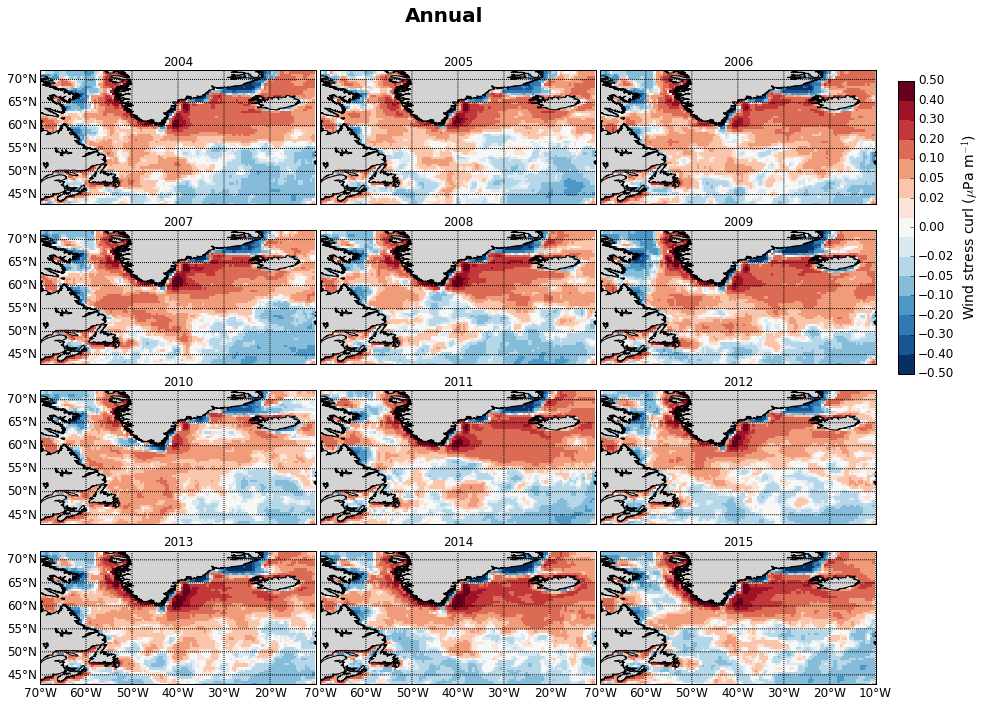

In [23]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('Annual', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl.lon-0.25,curl.lat-0.25,np.ma.masked_invalid(curl.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

#plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()

### Map of seasonal means

In [24]:
def seasonal_mean(data, months):
    data_cp = data.copy(deep=True)
    # save original times
    data_cp['time_orig'] = data_cp.time.copy()
    # set time = 1 for JJA and time=0 otherwise 
    data_cp.time.values = [(1 if t.month in months else 0) \
                           for t in data_cp.time.values.astype('M8[D]').astype('O')]
    data_seasonal = data_cp.sel(time=1)
    # restore time coordinate to original times
    data_seasonal.time.values = data_seasonal.time_orig.values
    del data_seasonal.coords['time_orig']
    
    data_seasonal_mean = data_seasonal.groupby('time.year').mean('time')
        
    return data_seasonal_mean

In [25]:
curl = ds.sel(lat=slice(south,north),lon=slice(west,east)).curl

In [26]:
curl_jfm = seasonal_mean(curl,(1,2,3))
curl_amj = seasonal_mean(curl,(4,5,6))
curl_jja = seasonal_mean(curl,(6,7,8))
curl_jas = seasonal_mean(curl,(7,8,9))
curl_ond = seasonal_mean(curl,(10,11,12))

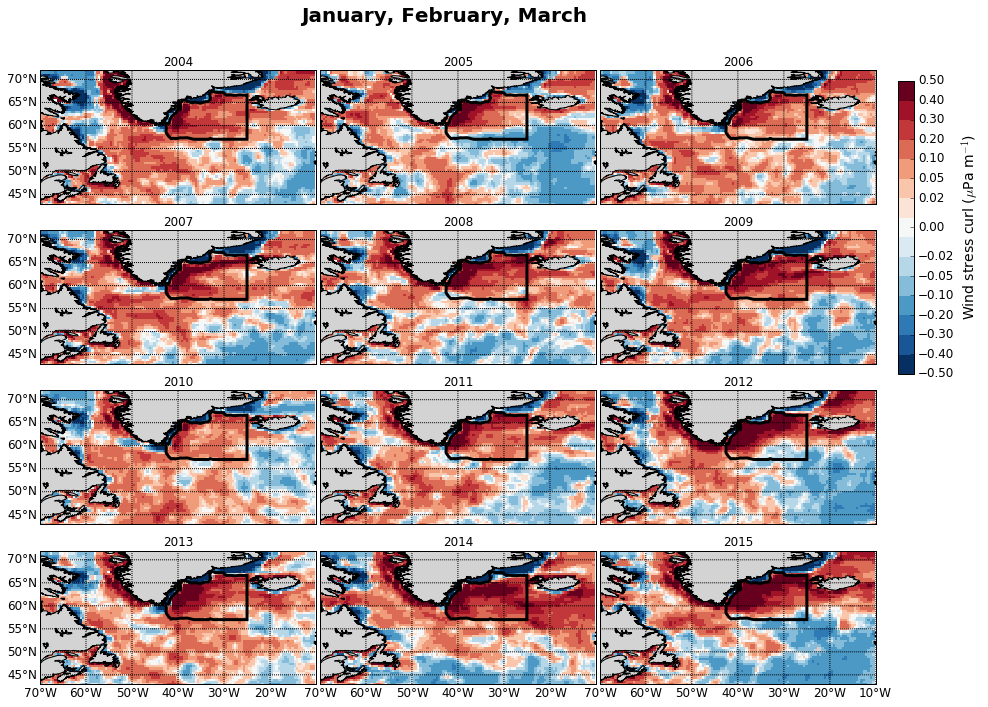

In [28]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('January, February, March', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl_jfm.lon-0.25,curl_jfm.lat-0.25,np.ma.masked_invalid(curl_jfm.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))
        patch04 = Polygon(v[0:count], facecolor='none',edgecolor='k', linewidth=3)
        axs[row][col].add_patch(patch04)

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

#plt.savefig('/Users/jet/Downloads/jfm.png')
plt.show()

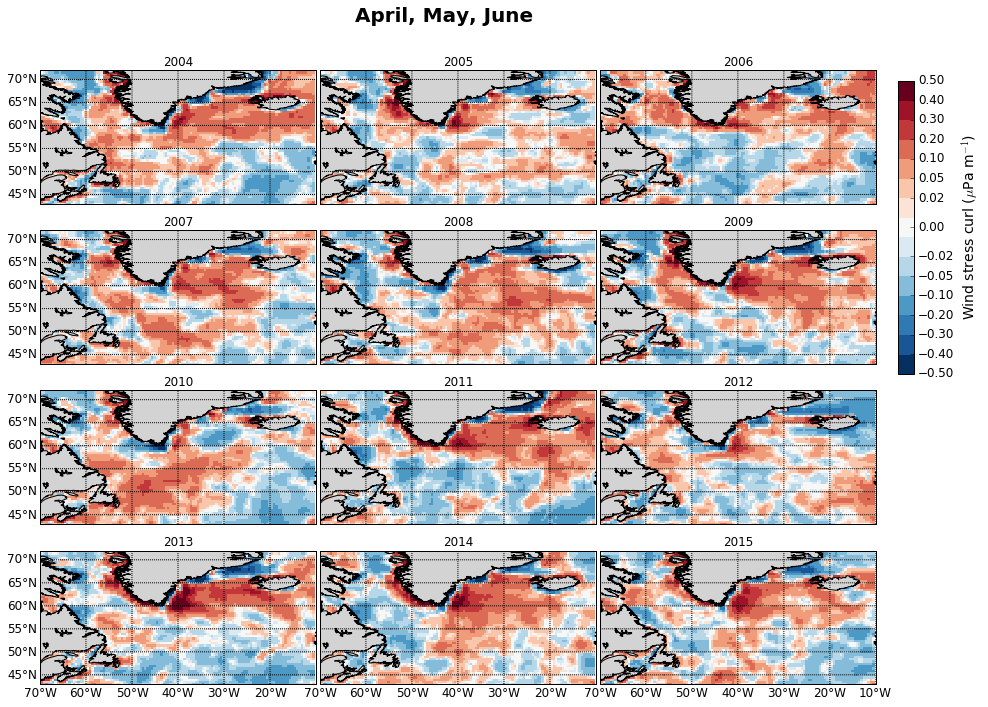

In [48]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('April, May, June', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl_amj.lon-0.25,curl_amj.lat-0.25,np.ma.masked_invalid(curl_amj.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('/Users/jet/Downloads/amj.png')
plt.show()

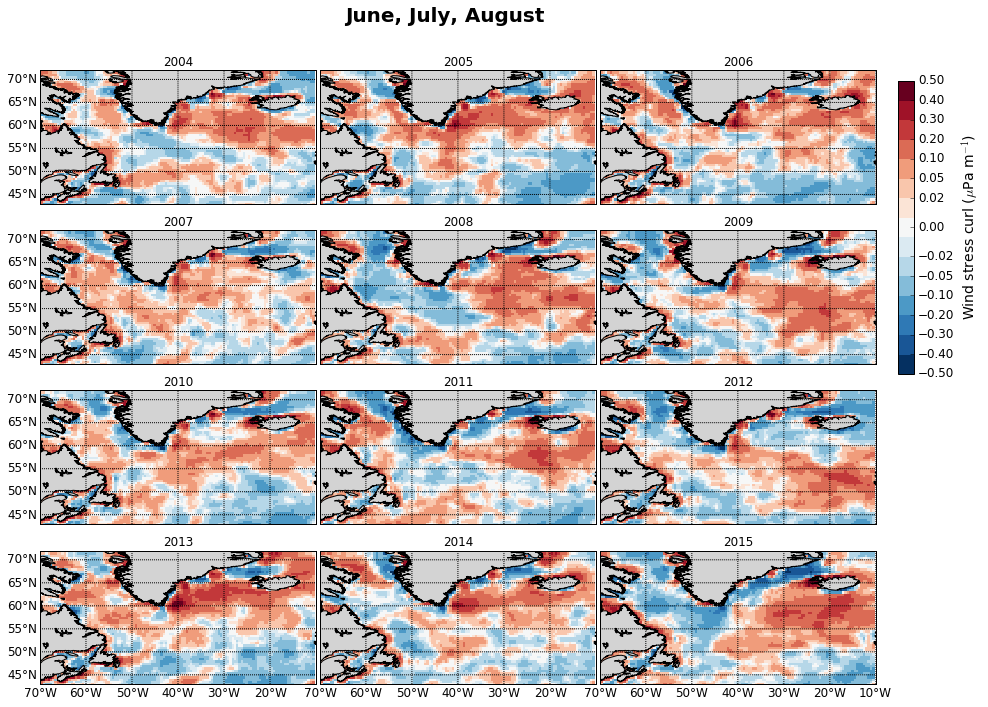

In [49]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('June, July, August', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl_jja.lon-0.25,curl_jja.lat-0.25,np.ma.masked_invalid(curl_jja.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('/Users/jet/Downloads/jja.png')
plt.show()

In [19]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('July, August, September', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl_jas.lon-0.25,curl_jas.lat-0.25,np.ma.masked_invalid(curl_jas.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('/Users/jet/Downloads/jas.png')
plt.show()

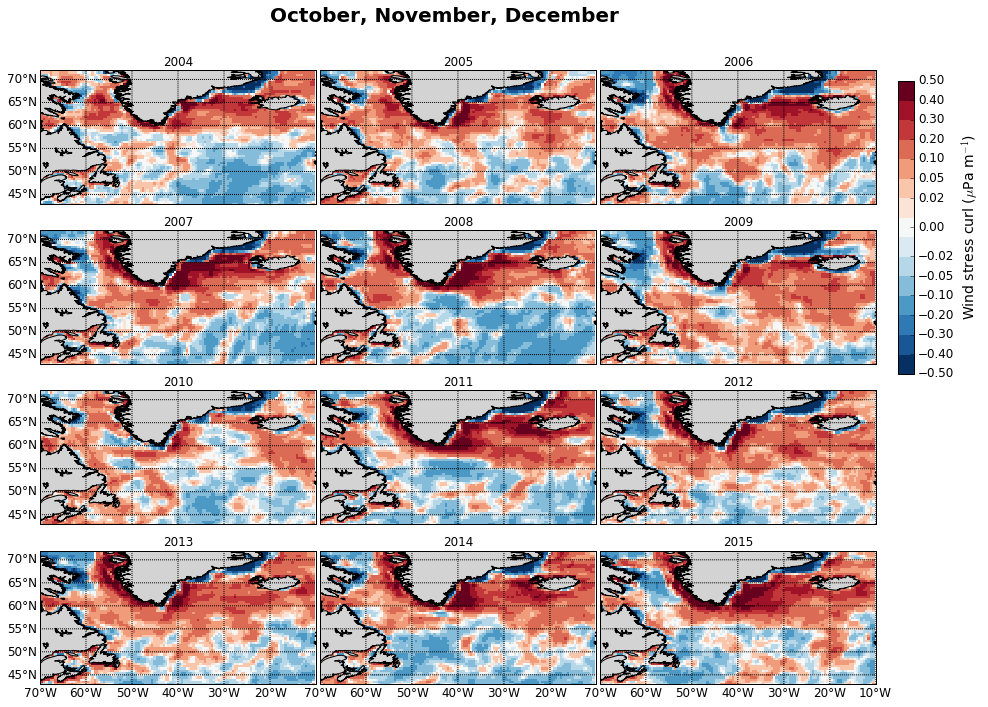

In [51]:
f, axs = plt.subplots(4, 3, figsize=(15,11))
f.suptitle('October, November, December', fontsize=20, fontweight='bold')
for row in range(0,4):
    for col in range(0,3):
        
        yr = 2003 + 3*row + col + 1
        m = Basemap(projection='cyl',llcrnrlat=43, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l', ax=axs[row][col])
        m.fillcontinents(color='lightgrey')
        m.drawcoastlines()
        m.drawparallels(np.arange(-80,90,5),labels=[1 if col==0 else 0,0,0,0], fontsize=12)
        m.drawmeridians(np.arange(-70,0 if col==2 else -10,10),labels=[0,0,0,1 if row==3 else 0], fontsize=12)
        p = m.pcolormesh(curl_ond.lon-0.25,curl_ond.lat-0.25,np.ma.masked_invalid(curl_ond.sel(year=yr)*10**6),
                         cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
        axs[row][col].set_title('%s' % datetime.date(yr, 1, 15).strftime('%Y'))

f.subplots_adjust(wspace=0.01, hspace=0.2, right=0.9)

cbar_ax = f.add_axes([0.92, 0.517, 0.015, 0.37])
cbar = f.colorbar(p, ticks=ticks, cax=cbar_ax)
cbar.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('/Users/jet/Downloads/ond.png')
plt.show()

### Map of $\sigma_0$ at 300 dbar and wind stress curl

In [32]:
aviso1x1 = xray.open_dataset('/Users/jet/data/aviso1x1.nc').rename({'LATITUDE':'lat', 'LONGITUDE': 'lon'})

In [33]:
ds_pden = xray.open_dataset('/Users/jet/data/RG_ArgoClim/RG_ArgoClim_Pden_north_atlantic.nc')
ds_pden

<xarray.Dataset>
Dimensions:  (lat: 55, lon: 85, pres: 58, time: 149)
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15 2004-02-15 2004-03-15 ...
  * pres     (pres) float32 2.5 10.0 20.0 30.0 40.0 50.0 60.0 70.0 80.0 90.0 ...
  * lat      (lat) float32 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5 ...
  * lon      (lon) float32 -84.5 -83.5 -82.5 -81.5 -80.5 -79.5 -78.5 -77.5 ...
Data variables:
    sigma0   (time, pres, lat, lon) float32 nan nan nan nan nan nan nan nan ...

In [34]:
# Define subset around the subpolar gyre
patch_sg_lats = [50, 65, 65, 50]
patch_sg_lons = [-60, -60, -30, -30]

mdt_subset = aviso1x1.MDT.sel(lat=slice(np.min(patch_sg_lats),np.max(patch_sg_lats)),
                              lon=slice(np.min(patch_sg_lons),np.max(patch_sg_lons)))

In [35]:
sig0 = ds_pden.sigma0.sel(lat=slice(south,north),lon=slice(west,east))

In [36]:
mdt_max = -0.56
sig0_patch_sg = sig0.where(mdt_subset<mdt_max)

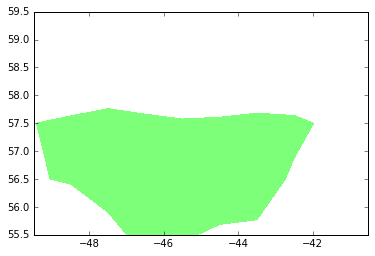

In [37]:
# Set threshold to define central subpolar gyre region with maximal density at pressure 360 dbar

sig_min = 27.702
sig0_patch_sg_central = sig0_patch_sg.sel(lat=slice(55,60),lon=slice(-50,-40))
sig0_patch_sg_central_max = sig0_patch_sg_central.where(sig0_patch_sg_central.sel(pres=360).mean('time')>=sig_min)
sig_patch = mdt_subset.where(mdt_subset<mdt_max)

p0 = plt.contourf(sig0_patch_sg_central.lon,sig0_patch_sg_central.lat,
                  np.ma.masked_invalid(sig0_patch_sg_central.sel(pres=360).mean('time')),
                  levels=[sig_min,27.71],cmap='jet')

# Get contour line of selected area
path = p0.collections[0].get_paths()[0]
v_sg = path.vertices

x0 = v[0,0]
y0 = v[0,1]
count = 0
for (x,y) in v_sg:
    if count >0 and x == x0 and y == y0:
        break;
    #print (count,x,y)
    count += 1

In [38]:
curl = ds.curl.sel(lat=slice(south,north),lon=slice(west,east))
curl_mean = curl.mean('time')

In [ ]:
p0 = plt.contourf(curl_subset.lon,curl_subset.lat,
                  np.ma.masked_invalid(curl_subset.mean('time')),
                  levels=[0.05*10**-6,np.max(curl_subset.mean('time'))],cmap='jet')

# Get contour line of selected area
path = p0.collections[0].get_paths()[0]
v = path.vertices

x0 = v[0,0]
y0 = v[0,1]
count = 0
for (x,y) in v:
    if count >0 and x == x0 and y == y0:
        break;
    #print (count,x,y)
    count += 1

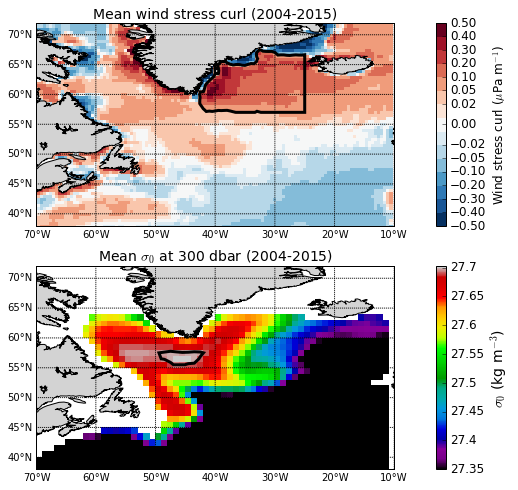

In [42]:
f,axes = plt.subplots(2,1,figsize=(15,8))

plt.subplot(2,1,1)
plt.title('Mean wind stress curl (2004-2015)',fontsize=14)
m = Basemap(projection='cyl',llcrnrlat=38, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-80,90,5),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-70,10,10),labels=[0,0,0,1], fontsize=10)
p = m.pcolormesh(curl_mean.lon-0.25,curl_mean.lat-0.25,
                 np.ma.masked_invalid(curl_mean*ds.lsm*10**6),
                 cmap='RdBu_r',vmin=-0.5,vmax=0.5, norm=norm)
patch04 = Polygon(v[0:count], facecolor='none',edgecolor='k', linewidth=3)
plt.gca().add_patch(patch04)
cb = f.colorbar(p,ticks=ticks)
cb.set_label(r'Wind stress curl ($\mu$Pa m$^{-1}$)',fontsize=12)
cb.ax.tick_params(labelsize=12)

plt.subplot(2,1,2)
plt.title('Mean $\sigma_0$ at 300 dbar (2004-2015)',fontsize=14)
m = Basemap(projection='cyl',llcrnrlat=38, urcrnrlat=72, llcrnrlon=-70, urcrnrlon=-10,
            lat_ts=0, resolution='l')
m.fillcontinents(color='lightgrey')
m.drawcoastlines()
m.drawparallels(np.arange(-80,90,5),labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-70,10,10),labels=[0,0,0,1], fontsize=10)
p = m.pcolormesh(sig0.lon-0.5,sig0.lat-0.5,np.ma.masked_invalid(sig0.sel(pres=300).mean('time')),
                 cmap='spectral',vmin=27.35)
patch_sg = Polygon(v_sg[0:count], facecolor='none',edgecolor='k', linewidth=3)
plt.gca().add_patch(patch_sg)

cb = f.colorbar(p,ticks=np.arange(27.35,27.75,0.05))
cb.set_label(r'$\sigma_0$ (kg m$^{-3}$)',fontsize=14)
cb.ax.tick_params(labelsize=12)
cb.ax.set_yticklabels(np.arange(27.35,27.75,0.05))

plt.savefig('/Users/jet/Downloads/figure.png')
plt.show()